# DFT and inverse DFT with PyDynamic - best practice guide

The discrete Fourier transform (DFT) and its inverse (iDFT) are common tools in dynamic metrology. For the corresponding propagation of uncertainties, *PyDynamic* implements the main tools required:

**Uncertainty propagation for the discrete Fourier transform**
```python 
    GUM_DFT(x,Ux,N=None,window=None,CxCos=None,CxSin=None,returnC=False,mask=None)
```

**Uncertainty propagation for the inverse discrete Fourier transform**
```python
    GUM_iDFT(F,UF,Nx=None,Cc=None,Cs=None,returnC=False)
```

**Uncertainty propagation for convolution in the frequency domain**
```python
    DFT_multiply(Y, UY, F, UF=None)
```

**Uncertainty propagation for deconvolution in the frequency domain**
```python
    DFT_deconv(H, Y, UH, UY)
```

In the following we discuss common use cases for these methods and present guidance on how to utilize the optional arguments of the above methods.

## Prerequisites

Get started with the notebook by importing some packages:

In [1]:
# base imports
import PyDynamic
import numpy
import matplotlib
import matplotlib.pyplot as plt
import scipy

# convenience imports
from numpy import sin, pi, random, fft, arange, sqrt, diag
from matplotlib.pyplot import plot,subplot, figure, errorbar
from PyDynamic.uncertainty.propagate_DFT import GUM_DFT, GUM_iDFT, DFT2AmpPhase, DFT_multiply, DFT_deconv

# set up matplotlib
%matplotlib notebook
matplotlib.rc('font', size=12)
matplotlib.rc('figure', figsize=(9,5))

# small helper function for visualization
def get_amplitudes(V):
    n = len(V)//2
    V_real = V[:n]
    V_imag = V[n:]
    return numpy.sqrt(V_real**2 + V_imag**2)

## 1) Discrete Fourier Transform (DFT)

The first and most basic scenario is the application of the discrete Fourier transform to analyse a time domain signal in the frequency domain. 

<IPython.core.display.Javascript object>


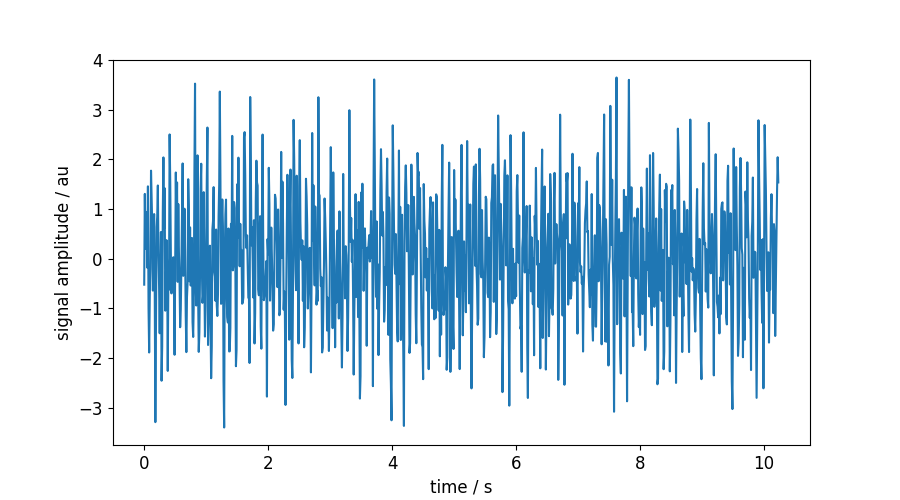

<IPython.core.display.Javascript object>


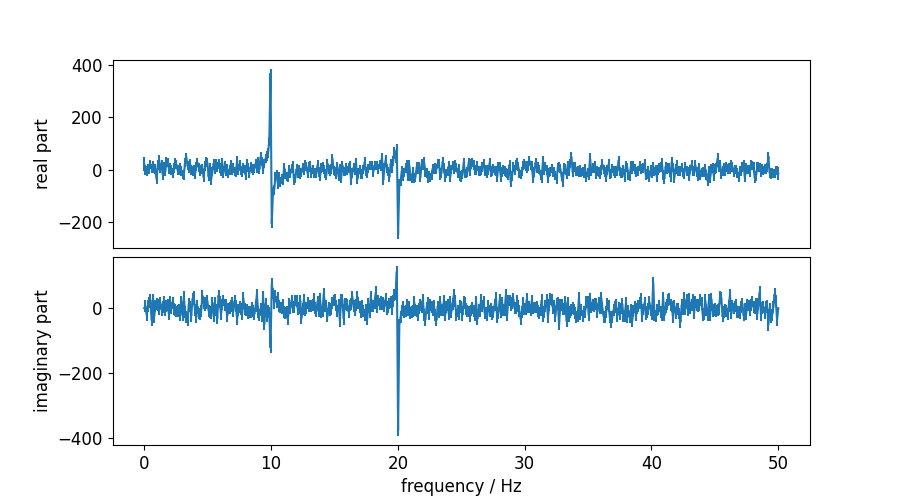

In [2]:
Fs = 100    # sampling frequency in Hz
Ts = 1/Fs   # sampling interval in s
N  = 1024   # number of samples
time = arange(0, N*Ts, Ts)  # time instants
noise_std = 0.8    # signal noise standard deviation

# time domain signal
x = sin(2*pi*Fs/10*time) + sin(2*pi*Fs/5*time) + random.randn(len(time))*noise_std
ux = noise_std**2 * numpy.ones_like(x)

X, UX = GUM_DFT(x, ux)    # application of DFT with propagation of uncertainties
f = fft.rfftfreq(N, Ts)   # frequency values

figure()
plot(time, x)
plt.xlabel("time / s")
plt.ylabel("signal amplitude / au");

figure()
subplot(211)
errorbar(f, X[:len(f)], sqrt(diag(UX)[:len(f)]))
plt.ylabel("real part")
plt.xticks([])
subplot(212)
errorbar(f, X[len(f):], sqrt(diag(UX)[len(f):]))
plt.ylabel("imaginary part")
plt.xlabel("frequency / Hz")
plt.subplots_adjust(hspace=0.05)

## 2) Inverse Discrete Fourier Transform (iDFT)

Let's transform our signal spectrum back into the time-domain. This yields in an _exact_ identitiy of `x` and `x_back_and_forth` and their assigned uncertainties. (Of course, this should be of no surprise, as we didn't modify anything and the DFT and iDFT form an identity pair.)

<IPython.core.display.Javascript object>


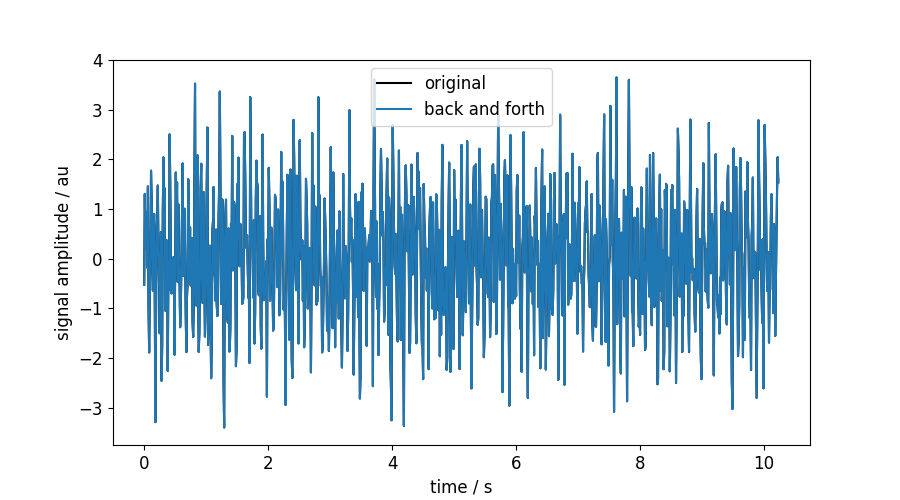

<IPython.core.display.Javascript object>


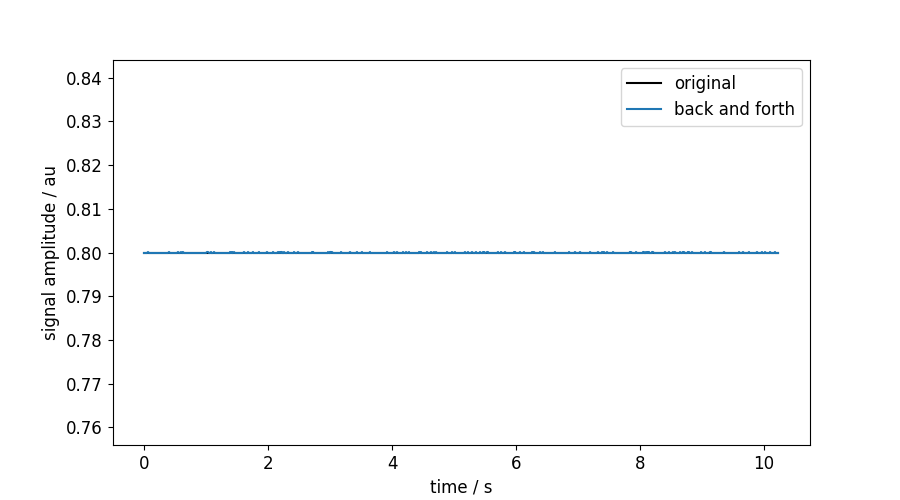

In [3]:
# transform the frequency spectrum back to the time domain
x_back_and_forth, ux_back_and_forth = GUM_iDFT(X, UX)

# visualize the time-signal
figure()
plot(time, x, '-k', label='original')
plot(time, x_back_and_forth, label='back and forth')
plt.xlabel("time / s")
plt.ylabel("signal amplitude / au")
plt.legend()

# visualize the uncertainties associated with x and x_back_and_forth
figure()
plot(time, sqrt(ux), '-k', label='original')
plot(time, sqrt(diag(ux_back_and_forth)), label='back and forth')
plt.xlabel("time / s")
plt.ylabel("signal amplitude / au")
plt.legend()


## 3) Multiply Spectra in the Frequency Domain

Multiplication in the frequency domain corresponds to a convolution of two signals in the time domain. 

Let's consider again the signal `x` from above. We have already transformed it to the frequecy domain in section 1), which resulted in the spectrum `X` of the signal. We now want to apply a lowpass filter `H` that removes the higher of the both dominant frequencies. So we should design a filter such that it has a cutoff frequency around 15Hz. 


Note: `butter` and `freqs` both require the frequency arguments to be angular frequencies. In favour of readability and without any consequences in our case, this is ommited. 

<IPython.core.display.Javascript object>


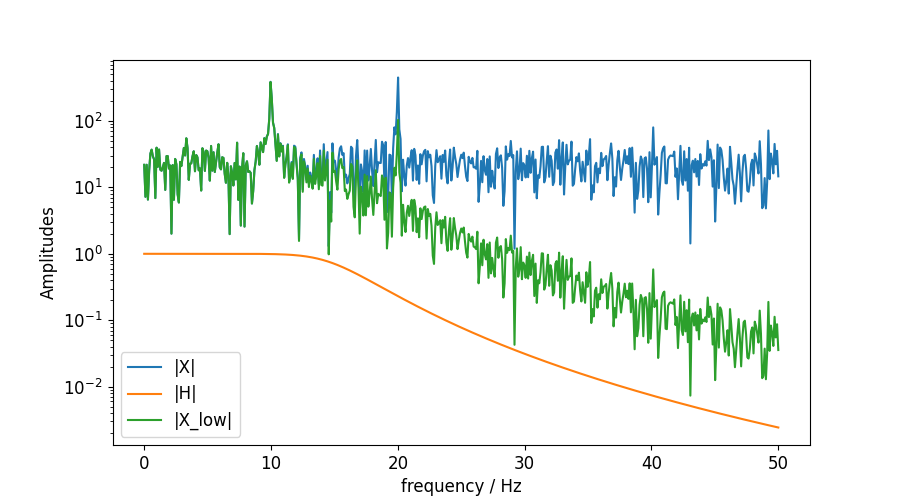

<IPython.core.display.Javascript object>


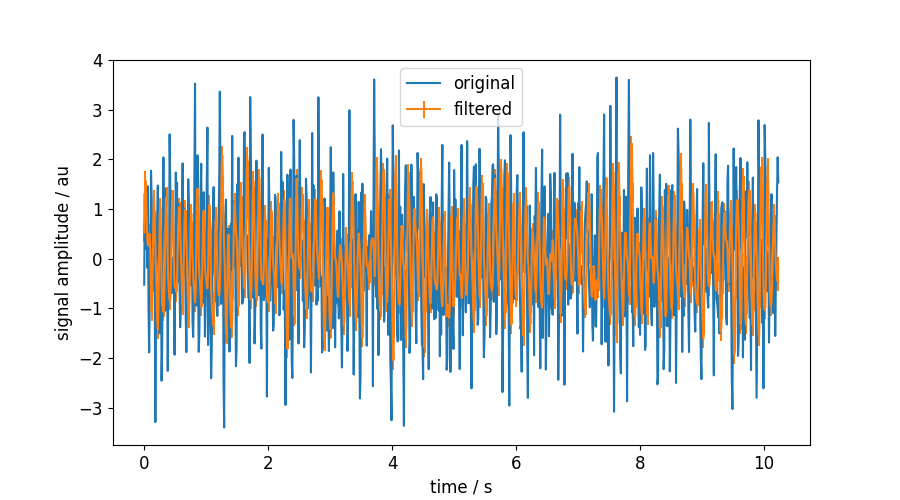

In [4]:
cutoff_frequency = 15
b, a = scipy.signal.butter(5, cutoff_frequency, 'low', analog=True)
_, H = scipy.signal.freqs(b, a, worN = f)  # get our filter at the same positions as X is already known

# bring H into the required shape for DFT_multiply
H = numpy.hstack((numpy.real(H), numpy.imag(H)))

# apply the lowpass H to X
X_low, UX_low = DFT_multiply(X, H, UX)

# visualize the multiplication by showing its effect on spectrum amplitudes
figure()
plt.plot(f, get_amplitudes(X), label="|X|")
plt.plot(f, get_amplitudes(H), label="|H|")
plt.plot(f, get_amplitudes(X_low), label="|X_low|")
plt.xlabel("frequency / Hz")
plt.ylabel("Amplitudes")
plt.yscale("log")
plt.legend()

# visualize the time-domain by comparing the original `x` and lowpass-filtered `x_low` signals
x_low, ux_low = GUM_iDFT(X_low, UX_low)
figure()
plot(time, x, label='original')
errorbar(time, x_low, diag(ux_low), label='filtered')
plt.xlabel("time / s")
plt.ylabel("signal amplitude / au")
plt.legend()

## 4) Deconvolve Signals by Division of Spectra

It could be of interest to remove the effect of a system's transfer function on a signal. This can be achieved in the frequency domain by a simple division of the signal spectrum and the system's transfer function. This corresponds to a deconvolution in the time-domain (a.k.a. convolution with the inverse filter). 

In our example, let's undo the lowpass operation from the last section. But to make it a bit more interesting, let's assume, we don't know the exact cutoff-frequency but only with an uncertainty of 1Hz. 

There are two steps:

1. Check the influence of the cutoff frequency on the actual frequency spectrum. This is done by a Monte Carlo method. 
2. Division of both spectra: The reconstructed signal can then be transformed back to the time-domain, where the uncertainties of original and reconstruction are compared. 

<IPython.core.display.Javascript object>


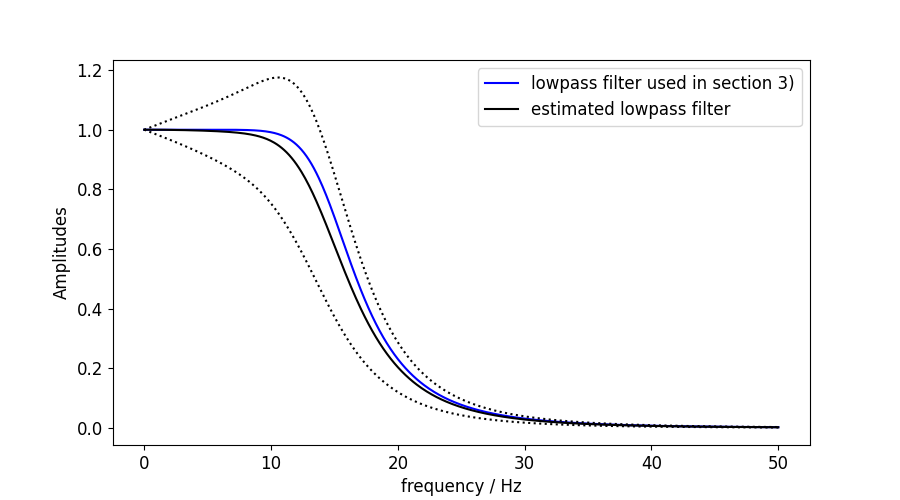

In [5]:
cutoff_frequency_estimate = 14.5  # Hz
cutoff_frequency_unc = 1.0  # Hz

# step 1: Monte Carlo
mc_runs = 100
h_array = numpy.empty((mc_runs, len(f)), dtype="complex")
for i in range(mc_runs):
    cf = random.normal(cutoff_frequency_estimate, cutoff_frequency_unc)
    b, a = scipy.signal.butter(5, cf, 'low', analog=True)
    _, H_tmp = scipy.signal.freqs(b, a, worN = f)
    h_array[i,:] = H_tmp

H_estimated_lowpass = numpy.hstack((numpy.mean(numpy.real(h_array), axis=0), numpy.mean(numpy.imag(h_array), axis=0)))
UH_estimated_lowpass = numpy.hstack((numpy.std(numpy.real(h_array), axis=0), numpy.std(numpy.imag(h_array), axis=0)))

# visualize the uncertain lowpass filter
a = get_amplitudes(H_estimated_lowpass)
u = get_amplitudes(UH_estimated_lowpass)

figure()
plot(f, get_amplitudes(H), "-b", label="lowpass filter used in section 3)")
plot(f, a, "-k", label="estimated lowpass filter")
plot(f, a + u, ":k")
plot(f, a - u, ":k")
plt.xlabel("frequency / Hz")
plt.ylabel("Amplitudes")
plt.yscale("linear")
plt.legend()

<IPython.core.display.Javascript object>


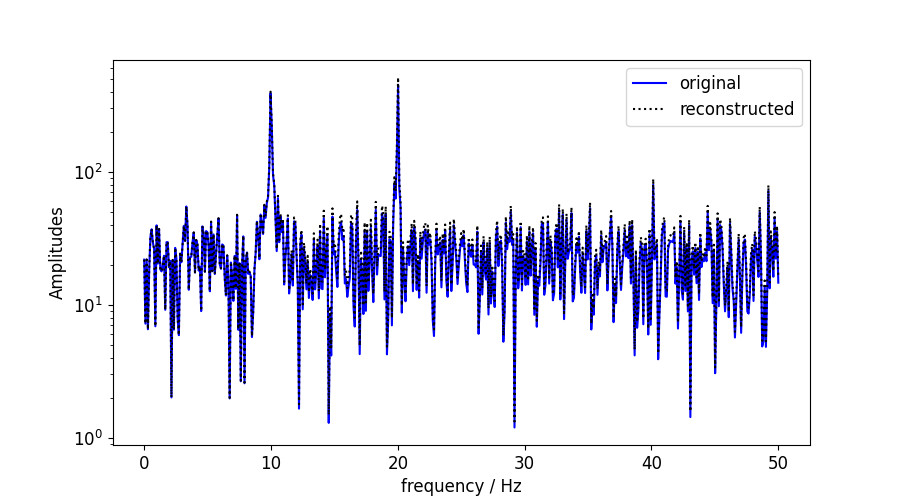

<IPython.core.display.Javascript object>


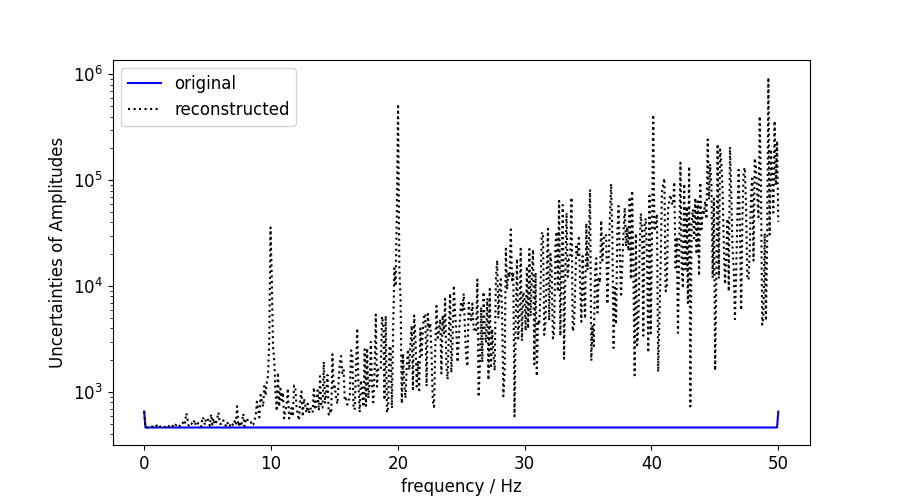

In [6]:
# step 2
X_recon, UX_recon = DFT_deconv(H_estimated_lowpass, X_low, diag(UH_estimated_lowpass), UX_low)

# visualize the uncertain reconstruction the spectrum amplitudes
figure()
plot(f, get_amplitudes(X), "-b", label="original")
plot(f, get_amplitudes(X_recon), ":k", label="reconstructed")
plt.xlabel("frequency / Hz")
plt.ylabel("Amplitudes")
plt.yscale("log")
plt.legend()

# visualize the uncertain reconstruction the spectrum amplitude uncertainties
figure()
plot(f, get_amplitudes(diag(UX)), "-b", label="original")
plot(f, get_amplitudes(diag(UX_recon)), ":k", label="reconstructed")
plt.xlabel("frequency / Hz")
plt.ylabel("Uncertainties of Amplitudes")
plt.yscale("log")
plt.legend()

Note: 
We just divided by the lowpass' transfer function. To readers with some background in control theory it should be obvious that this amplifies high frequencies and might lead to instabilities if used inside a control loop. However, because we are taking the signal's and filter's uncertaintiy into account, the reconstructed spectrum shows us just that - _that the higher spectrum values are much more uncertain._